# <center> House Prices -- Advance Regression Technique </center>
----

data source: https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques/data?select=test.csv

**Aim** : To build a predictive model to predict housing price



In [1]:
import inflection as infl
import math
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.figure_factory as ff
import plotly.graph_objects as go

from IPython.display import clear_output
from plotly.subplots import make_subplots
from scipy.stats import linregress, uniform, randint 
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.feature_selection import mutual_info_regression, r_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MaxAbsScaler, StandardScaler
from sklearn.tree import DecisionTreeRegressor


In [2]:
##### helper functions

def dataframe_summary(dataframe: pd.DataFrame,
                      max_length: int):
    
    pd.options.display.float_format = '{:,.4f}'.format

    ### Get list of column names
    col_names = dataframe.columns.to_list()

    ### Get unique count of each column
    col_length = [len(dataframe[val].unique()) for val in col_names]

    ### Append info for dataframe
    col_names.append("this_df")
    col_length.append(len(dataframe))

    ### Create new dataframe for summary
    summary_df = pd.DataFrame(list(zip(col_names, col_length)), columns=["column_name", "unique_count"])
    summary_df["uniqueness"] = summary_df["unique_count"]/len(dataframe) * 100

    ### Count nan values in each column
    nan_df = dataframe.isnull().sum(axis = 0).to_frame().reset_index().rename(columns={"index":"column_name", 0:"nan_count"})
    nan_df["nan_percent"] = nan_df["nan_count"]/len(dataframe)*100
    nan_df["percent_complete"] = 100 - nan_df["nan_percent"]

    ### Create new frame for data type in each column
    type_df = dataframe.dtypes.to_frame().reset_index().rename(columns={"index":"column_name", 0:"data_type"})
    type_df["data_type"] = type_df["data_type"].astype(str)

    ### Create new dataframe with unique entries for each column

    col_name = []
    unique_val = []
    
    for val  in dataframe.columns.to_list():

        col_name.append(val)

        if len(dataframe[val].unique())<=max_length:
            unique_val.append(list(dataframe[val].unique()))

        else:
            unique_val.append(f">{max_length} entries")

    unique_df = pd.DataFrame(list(zip(col_name, unique_val)),
                             columns=["column_name", "unique_entries"])
    
    

    ### Merge summary_df with nan_df, type_df
    summary_df = summary_df.merge(nan_df, on="column_name", how="outer")
    summary_df = summary_df.merge(type_df, on="column_name", how="outer")
    summary_df = summary_df.merge(unique_df, on="column_name", how="outer")


    return summary_df.sort_values(["data_type", "nan_count"])


def describe_dataframe(dataframe: pd.DataFrame):
    
    pd.options.display.float_format = '{:,.3f}'.format
    
    return dataframe.select_dtypes([int, float]).describe()


In [6]:
##### load house price data and rename column to snake case
raw_df = pd.read_csv("house_price_train.csv")
raw_df.columns = [infl.underscore(val) for val in raw_df.columns]

raw_df.head(5)


id  ms_sub_class ms_zoning  lot_frontage  lot_area street alley lot_shape  \
0   1            60        RL          65.0      8450   Pave   NaN       Reg   
1   2            20        RL          80.0      9600   Pave   NaN       Reg   
2   3            60        RL          68.0     11250   Pave   NaN       IR1   
3   4            70        RL          60.0      9550   Pave   NaN       IR1   
4   5            60        RL          84.0     14260   Pave   NaN       IR1   

  land_contour utilities  ... pool_area pool_qc fence misc_feature misc_val  \
0          Lvl    AllPub  ...         0     NaN   NaN          NaN        0   
1          Lvl    AllPub  ...         0     NaN   NaN          NaN        0   
2          Lvl    AllPub  ...         0     NaN   NaN          NaN        0   
3          Lvl    AllPub  ...         0     NaN   NaN          NaN        0   
4          Lvl    AllPub  ...         0     NaN   NaN          NaN        0   

  mo_sold yr_sold  sale_type  sale_condition  sale_price  
0       2    2008         WD          Normal      208500  
1       5    2007         WD          Normal      181500  
2       9    2008         WD          Normal      223500  
3       2    2006         WD         Abnorml      140000  
4      12    2008         WD          Normal      250000  

[5 rows x 81 columns]

---
# <center> Exploratory Data Analysis </center>
 
---

In [14]:
data_types =raw_df.dtypes.to_frame().reset_index().rename(columns={0:"data_type", "index":"column_name"}).groupby("data_type").count()
data_types

column_name
data_type             
int64               35
float64              3
object              43

In [32]:
raw_summary = dataframe_summary(raw_df, 15).sort_values("data_type")
raw_summary[raw_summary["nan_percent"]<1]

column_name  unique_count  uniqueness  nan_count  nan_percent  \
26     mas_vnr_area           328     22.4658     8.0000       0.5479   
51   bedroom_abv_gr             8      0.5479     0.0000       0.0000   
52   kitchen_abv_gr             4      0.2740     0.0000       0.0000   
54  tot_rms_abv_grd            12      0.8219     0.0000       0.0000   
56       fireplaces             4      0.2740     0.0000       0.0000   
..              ...           ...         ...        ...          ...   
24      exterior2nd            16      1.0959     0.0000       0.0000   
27       exter_qual             4      0.2740     0.0000       0.0000   
28       exter_cond             5      0.3425     0.0000       0.0000   
29       foundation             6      0.4110     0.0000       0.0000   
40       heating_qc             5      0.3425     0.0000       0.0000   

    percent_complete data_type                              unique_entries  
26           99.4521   float64                                 >15 entries  
51          100.0000     int64                    [3, 4, 1, 2, 0, 5, 6, 8]  
52          100.0000     int64                                [1, 2, 3, 0]  
54          100.0000     int64    [8, 6, 7, 9, 5, 11, 4, 10, 12, 3, 2, 14]  
56          100.0000     int64                                [0, 1, 2, 3]  
..               ...       ...                                         ...  
24          100.0000    object                                 >15 entries  
27          100.0000    object                            [Gd, TA, Ex, Fa]  
28          100.0000    object                        [TA, Gd, Fa, Po, Ex]  
29          100.0000    object  [PConc, CBlock, BrkTil, Wood, Slab, Stone]  
40          100.0000    object                        [Ex, Gd, TA, Fa, Po]  

[64 rows x 8 columns]

In [37]:
raw_10_list = raw_summary.loc[raw_summary["nan_percent"]<10, "column_name"].to_list()

raw_df_10 = raw_df[raw_10_list]

raw_df_10.head(5)

mas_vnr_area  garage_yr_blt  bedroom_abv_gr  kitchen_abv_gr  \
0      196.0000     2,003.0000               3               1   
1        0.0000     1,976.0000               3               1   
2      162.0000     2,001.0000               3               1   
3        0.0000     1,998.0000               3               1   
4      350.0000     2,000.0000               4               1   

   tot_rms_abv_grd  fireplaces  garage_cars  garage_area  open_porch_sf  \
0                8           0            2          548             61   
1                6           1            2          460              0   
2                6           1            2          608             42   
3                7           1            3          642             35   
4                9           1            3          836             84   

   3_ssn_porch  ...  bldg_type  house_style  roof_style  roof_matl  \
0            0  ...       1Fam       2Story       Gable    CompShg   
1            0  ...       1Fam       1Story       Gable    CompShg   
2            0  ...       1Fam       2Story       Gable    CompShg   
3            0  ...       1Fam       2Story       Gable    CompShg   
4            0  ...       1Fam       2Story       Gable    CompShg   

   exterior1st  exterior2nd  exter_qual  exter_cond  foundation  heating_qc  
0      VinylSd      VinylSd          Gd          TA       PConc          Ex  
1      MetalSd      MetalSd          TA          TA      CBlock          Ex  
2      VinylSd      VinylSd          Gd          TA       PConc          Ex  
3      Wd Sdng      Wd Shng          TA          TA      BrkTil          Gd  
4      VinylSd      VinylSd          Gd          TA       PConc          Ex  

[5 rows x 74 columns]

In [144]:
def plot_distribution(data):

    column_names = data.columns

    rows_needed = int(len(column_names)/4) + 1

    fig = make_subplots(rows=rows_needed, cols=4, subplot_titles=column_names)

    for num, col_name in enumerate(column_names):

        fig.add_trace( go.Histogram(x=data[col_name], name=col_name, histnorm="probability", showlegend=False)
                      , row=int(num/4)+1, col=num%4+1)

    fig.update_layout(height=rows_needed*300)
    fig.show()


In [145]:
plot_distribution(raw_df_10)

In [91]:
drop_numeric_list = ["kitchen_abv_gr", "3_ssn_porch", "screen_porch", "pool_area", "misc_val", "enclosed_porch", "low_qual_fin_sf", "bsmt_fin_sf2" ]

numeric_10_df = raw_df_10.select_dtypes(include="number").drop(columns=drop_numeric_list)
numeric_10_df

mas_vnr_area  garage_yr_blt  bedroom_abv_gr  tot_rms_abv_grd  \
0         196.0000     2,003.0000               3                8   
1           0.0000     1,976.0000               3                6   
2         162.0000     2,001.0000               3                6   
3           0.0000     1,998.0000               3                7   
4         350.0000     2,000.0000               4                9   
...            ...            ...             ...              ...   
1455        0.0000     1,999.0000               3                7   
1456      119.0000     1,978.0000               3                7   
1457        0.0000     1,941.0000               4                9   
1458        0.0000     1,950.0000               2                5   
1459        0.0000     1,965.0000               3                6   

      fireplaces  garage_cars  garage_area  open_porch_sf  half_bath  mo_sold  \
0              0            2          548             61          1        2   
1              1            2          460              0          0        5   
2              1            2          608             42          1        9   
3              1            3          642             35          0        2   
4              1            3          836             84          1       12   
...          ...          ...          ...            ...        ...      ...   
1455           1            2          460             40          1        8   
1456           2            2          500              0          0        2   
1457           2            1          252             60          0        5   
1458           0            1          240              0          0        4   
1459           0            1          276             68          1        6   

      ...  overall_qual  year_built  year_remod_add  bsmt_fin_sf1  \
0     ...             7        2003            2003           706   
1     ...             6        1976            1976           978   
2     ...             7        2001            2002           486   
3     ...             7        1915            1970           216   
4     ...             8        2000            2000           655   
...   ...           ...         ...             ...           ...   
1455  ...             6        1999            2000             0   
1456  ...             6        1978            1988           790   
1457  ...             7        1941            2006           275   
1458  ...             5        1950            1996            49   
1459  ...             5        1965            1965           830   

      overall_cond  bsmt_unf_sf  total_bsmt_sf  1st_flr_sf  2nd_flr_sf  \
0                5          150            856         856         854   
1                8          284           1262        1262           0   
2                5          434            920         920         866   
3                5          540            756         961         756   
4                5          490           1145        1145        1053   
...            ...          ...            ...         ...         ...   
1455             5          953            953         953         694   
1456             6          589           1542        2073           0   
1457             9          877           1152        1188        1152   
1458             6            0           1078        1078           0   
1459             6          136           1256        1256           0   

      gr_liv_area  
0            1710  
1            1262  
2            1786  
3            1717  
4            2198  
...           ...  
1455         1647  
1456         2073  
1457         2340  
1458         1078  
1459         1256  

[1460 rows x 29 columns]

In [138]:
fig = make_subplots(rows=1, cols=1)

fig.add_trace(go.Heatmap(x=numeric_10_df.columns, y=numeric_10_df.columns, 
                         z=numeric_10_df.corr(), text=numeric_10_df.corr(), texttemplate="%{text:,.3f}",
                         colorscale="RdBu", 
                         zmid=0
                         ),
            row=1, col=1)

fig.update_coloraxes(cmid=0, row=1, col=1)

fig.update_layout(height=800)
fig.show()

In [142]:
numeric_corr_10 = numeric_10_df.corr()["sale_price"].to_frame().reset_index()
numeric_corr_10 = numeric_corr_10[numeric_corr_10["sale_price"]>=0.5]

numeric_corr_10



index  sale_price
3   tot_rms_abv_grd      0.5337
5       garage_cars      0.6404
6       garage_area      0.6234
11       sale_price      1.0000
12        full_bath      0.5607
19     overall_qual      0.7910
20       year_built      0.5229
21   year_remod_add      0.5071
25    total_bsmt_sf      0.6136
26       1st_flr_sf      0.6059
28      gr_liv_area      0.7086

In [192]:
def plot_scatter_xy(data, target_column, log_x=False, log_y=False):

    column_names = data.columns.to_list()
    column_names.remove(target_column)

    rows_needed = int(len(column_names)/4) + 1

    fig = make_subplots(rows=rows_needed, cols=4, subplot_titles=column_names)

    ##### Log transform
    if log_x==True:
        features = np.log(data[column_names])
    else:
        features = data[column_names]
        # features = (features - np.mean(features))/np.std(features)
    
    if log_y==True:
        target = np.log(data[target_column])
    else:
        target = data[target_column]

    ##### Plot
    for num, col_name in enumerate(column_names):

        fig.add_trace( go.Scatter(x=features[col_name], y=target, name=col_name 
                                  , mode="markers", marker=dict(color="#0F52BA"), showlegend=False)
                      , row=int(num/4)+1, col=num%4+1)

    fig.update_layout(height=rows_needed*300)
    fig.show()


In [193]:
coi = numeric_corr_10["index"].to_list()

plot_scatter_xy(raw_df_10[coi], "sale_price", log_y=True, log_x=False)

# Notes on raw data

* data shape:
    * rows: 1460
    * columns: 81

* number of columns based on data types:
    * numerics: 38
    * objects: 43

* percent missing data:
    * < 20%: 75 columns
    * < 10%: 74 columns
    * < 5%: 68 columns
    * < 1%: 64 columns

* some columns probably will not be much use since most of the entry consist of a single value. These columns will be dropped for now and they are:

| Numerical data | Categorical data | Categorical data|
| --- | --- | --- | 
| kitchen_abv_gr | functional | roof_matl ||
| 3_ssn_porch | sale_type | central_air |
| screen_porch | sale_condition | heating |
| pool area | electrical | ms_zoning |
| misc_val | bsmt_cond | street |
| enclosed_porch | garage_qual | land_contour |
| low_qual_fin_sf | garage_cond | utilities |
| bsmt_fin_sf2 | bsmt_fin_type2 | land_slope |
|| condition2 | condition1 |








----
# <center> Data Clean Up </center>
---

Determine the amount of rows with NaN values. The following features are removed since the amount missing values are >10%. 

ID was also removed since it does not contribute to the prediction.

| Feature | Description |
| --- | --- | 
| pool_qc | pool quality | 
| misc_feature | Miscellaneous features not covered in other categories | 
| alley |  Type of alley access to property | 
| fence |  Fence quality  | 
| mas_vnr_type |  Masonry veneer type -- Brick, stone, etc. | 
| fireplace_qu |  Fireplace quality | 
| lot_frontage |  Linear feet of street connected to property| 

In [195]:
house_df = raw_df.copy(deep=True)

##### introduce new columns
house_df["age_sold"] = house_df["yr_sold"] - house_df["year_built"]

# house_df["age_sold"]

In [198]:
col_names = [val for val in house_df.columns]
nan_count = [len(house_df.loc[house_df[val].isna(), val]) for val in house_df.columns]

nan_count_df = pd.DataFrame(list(zip(col_names, nan_count)), columns=["column", "nan_count"])
nan_count_df["nan_percent"] = nan_count_df["nan_count"]/len(house_df)*100

##### Display the column with NaN; sort according to the amount of NaN in columns
nan_count_df[nan_count_df["nan_percent"]>10].sort_values(["nan_count"], ascending=False)

column  nan_count  nan_percent
72       pool_qc       1453      99.5205
74  misc_feature       1406      96.3014
6          alley       1369      93.7671
73         fence       1179      80.7534
25  mas_vnr_type        872      59.7260
57  fireplace_qu        690      47.2603
3   lot_frontage        259      17.7397

In [199]:
##### remove features with more than 10% NaN row

nan_removal = nan_count_df.loc[nan_count_df["nan_percent"]>10, "column"].to_list()
nan_removal = nan_removal + ["id"]

cleaned_house_df = house_df.drop(columns=nan_removal)

cleaned_house_df.head(5)

ms_sub_class ms_zoning  lot_area street lot_shape land_contour utilities  \
0            60        RL      8450   Pave       Reg          Lvl    AllPub   
1            20        RL      9600   Pave       Reg          Lvl    AllPub   
2            60        RL     11250   Pave       IR1          Lvl    AllPub   
3            70        RL      9550   Pave       IR1          Lvl    AllPub   
4            60        RL     14260   Pave       IR1          Lvl    AllPub   

  lot_config land_slope neighborhood  ... 3_ssn_porch screen_porch pool_area  \
0     Inside        Gtl      CollgCr  ...           0            0         0   
1        FR2        Gtl      Veenker  ...           0            0         0   
2     Inside        Gtl      CollgCr  ...           0            0         0   
3     Corner        Gtl      Crawfor  ...           0            0         0   
4        FR2        Gtl      NoRidge  ...           0            0         0   

  misc_val  mo_sold  yr_sold  sale_type  sale_condition sale_price age_sold  
0        0        2     2008         WD          Normal     208500        5  
1        0        5     2007         WD          Normal     181500       31  
2        0        9     2008         WD          Normal     223500        7  
3        0        2     2006         WD         Abnorml     140000       91  
4        0       12     2008         WD          Normal     250000        8  

[5 rows x 74 columns]

---
# <center> Exploratory Data Analysis </center>
---



In [8]:
house_df_summary = dataframe_summary(cleaned_house_df, 10)
house_df_summary.sort_values(["percent_complete", "data_type"], ascending=[False, True])

column_name  unique_count  uniqueness  nan_count  nan_percent  \
0    ms_sub_class            15      1.0274     0.0000       0.0000   
2        lot_area          1073     73.4932     0.0000       0.0000   
14   overall_qual            10      0.6849     0.0000       0.0000   
15   overall_cond             9      0.6164     0.0000       0.0000   
16     year_built           112      7.6712     0.0000       0.0000   
..            ...           ...         ...        ...          ...   
53    garage_type             7      0.4795    81.0000       5.5479   
55  garage_finish             4      0.2740    81.0000       5.5479   
58    garage_qual             6      0.4110    81.0000       5.5479   
59    garage_cond             6      0.4110    81.0000       5.5479   
74        this_df          1460    100.0000        NaN          NaN   

    percent_complete data_type  \
0           100.0000     int64   
2           100.0000     int64   
14          100.0000     int64   
15          100.0000     int64   
16          100.0000     int64   
..               ...       ...   
53           94.4521    object   
55           94.4521    object   
58           94.4521    object   
59           94.4521    object   
74               NaN       NaN   

                                       unique_entries  
0                                         >10 entries  
2                                         >10 entries  
14                    [7, 6, 8, 5, 9, 4, 10, 3, 1, 2]  
15                        [5, 8, 6, 7, 4, 2, 3, 9, 1]  
16                                        >10 entries  
..                                                ...  
53  [Attchd, Detchd, BuiltIn, CarPort, nan, Basmen...  
55                               [RFn, Unf, Fin, nan]  
58                          [TA, Fa, Gd, nan, Ex, Po]  
59                          [TA, Fa, nan, Gd, Po, Ex]  
74                                                NaN  

[75 rows x 8 columns]

## Sale Price with Respect to Neighborhood

In [9]:
house_neighborhood = house_df[["neighborhood", "sale_price", "gr_liv_area", "age_sold"]].groupby(["neighborhood"]).agg(["mean", "median", "std"]).reset_index()
house_neighborhood = house_neighborhood.sort_values(("sale_price", "mean"), ascending=False)
house_neighborhood["mean_scaled"] = house_neighborhood["sale_price"]["mean"]/house_neighborhood["gr_liv_area"]["mean"]
house_neighborhood["median_scaled"] = house_neighborhood["sale_price"]["median"]/house_neighborhood["gr_liv_area"]["median"]



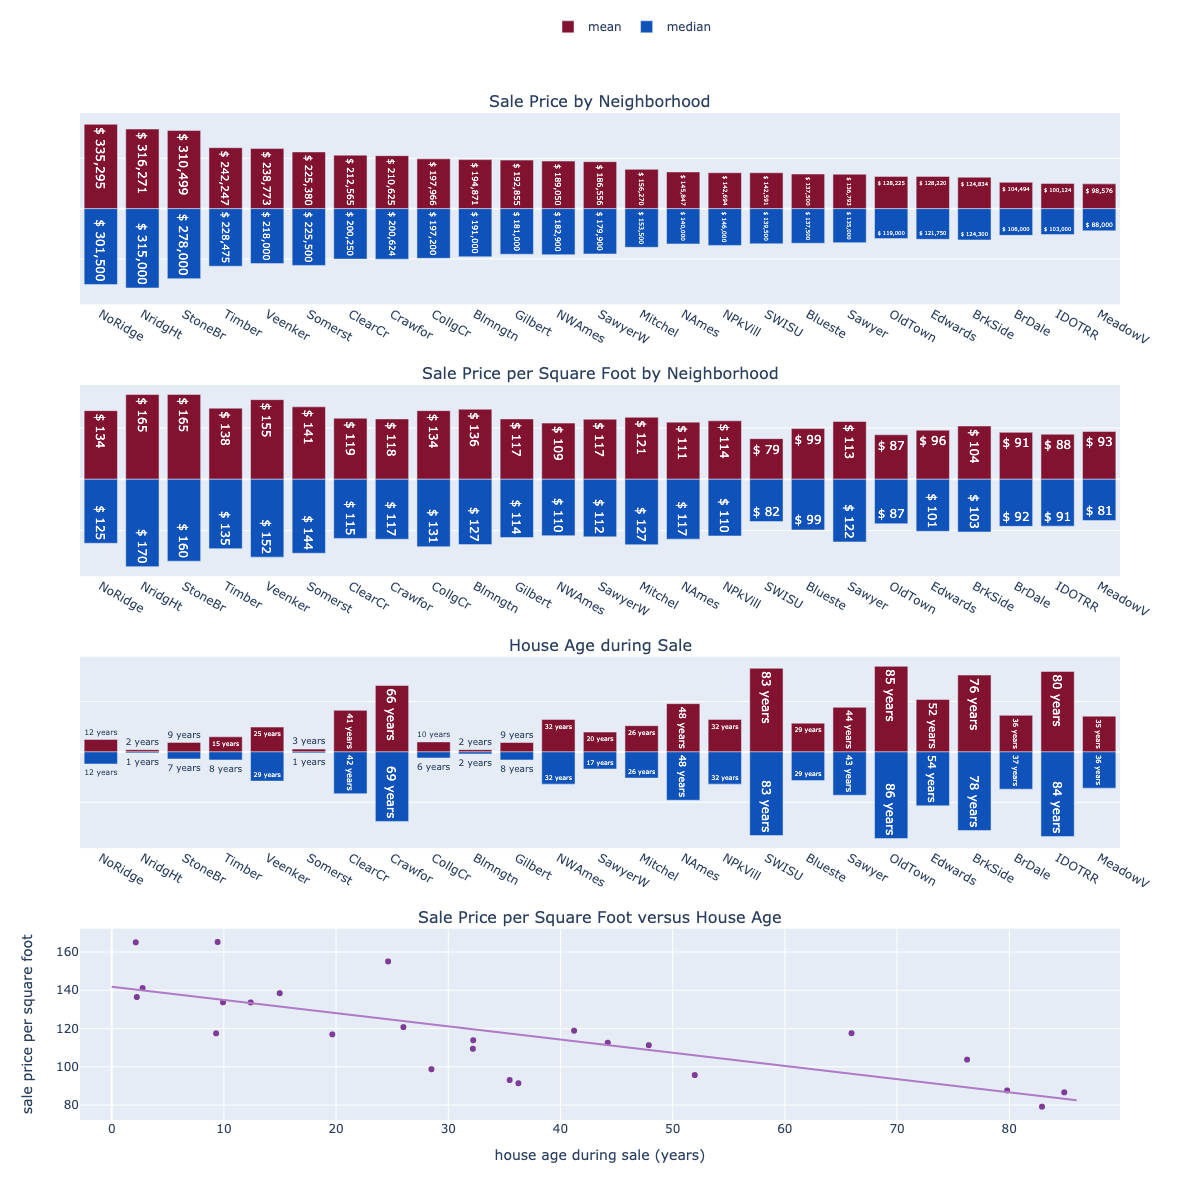

In [10]:
linregress_result = linregress(x=house_neighborhood[("age_sold", "mean")], y=house_neighborhood["mean_scaled"])
linregress_result

dummy_x = [val for val in range(87)]
dummy_y = [linregress_result[0]*val + linregress_result[1] for val in dummy_x]

fig_eda_1 = make_subplots(rows=4, cols=1, 
                          subplot_titles=["Sale Price by Neighborhood", "Sale Price per Square Foot by Neighborhood",
                                          "House Age during Sale", "Sale Price per Square Foot versus House Age"],
                            vertical_spacing=0.08)

fig_eda_1.add_trace( go.Bar(y=house_neighborhood["sale_price"]["mean"], x=house_neighborhood["neighborhood"], orientation="v",
                        text=house_neighborhood["sale_price"]["mean"], texttemplate='$ %{text:,.0f}', marker_color="#811331",
                        showlegend=True, legendgroup="mean", name="mean"), 
                 row=1, col=1)

fig_eda_1.add_trace( go.Bar(y=-1*house_neighborhood["sale_price"]["median"], x=house_neighborhood["neighborhood"], orientation="v", 
                        text=house_neighborhood["sale_price"]["median"], texttemplate='$ %{text:,.0f}', 
                        marker_color="#0F52BA",
                        showlegend=True, legendgroup="median", name="median"), 
                 row=1, col=1)

fig_eda_1.add_trace( go.Bar(y=house_neighborhood["mean_scaled"], x=house_neighborhood["neighborhood"], orientation="v",
                        text=house_neighborhood["mean_scaled"], texttemplate='$ %{text:,.0f}', marker_color="#811331",
                        showlegend=False, legendgroup="mean", name="mean"), 
                 row=2, col=1)

fig_eda_1.add_trace( go.Bar(y=-1*house_neighborhood["median_scaled"], x=house_neighborhood["neighborhood"], orientation="v", 
                        text=house_neighborhood["median_scaled"], texttemplate='$ %{text:,.0f}', 
                        marker_color="#0F52BA",
                        showlegend=False, legendgroup="median", name="median"), 
                 row=2, col=1)

fig_eda_1.add_trace( go.Bar(y=house_neighborhood["age_sold"]["mean"], x=house_neighborhood["neighborhood"], orientation="v",
                        text=house_neighborhood["age_sold"]["mean"], texttemplate='%{text:,.0f} years', marker_color="#811331",
                        showlegend=False, legendgroup="mean", name="mean"), 
                 row=3, col=1)

fig_eda_1.add_trace( go.Bar(y=-1*house_neighborhood["age_sold"]["median"], x=house_neighborhood["neighborhood"], orientation="v", 
                        text=house_neighborhood["age_sold"]["median"], texttemplate='%{text:,.0f} years', 
                        marker_color="#0F52BA",
                        showlegend=False, legendgroup="median", name="median"), 
                 row=3, col=1)

fig_eda_1.add_trace( go.Scatter(x=house_neighborhood[("age_sold", "mean")], y=house_neighborhood["mean_scaled"], 
                                mode="markers", showlegend=False, marker=dict(color="#7D3C98")),
                    row=4, col=1)

fig_eda_1.add_trace( go.Scatter(x=dummy_x, y=dummy_y, mode="lines", showlegend=False, marker=dict(color="#AF7AC5")),
                    row=4, col=1)


fig_eda_1.update_yaxes(showticklabels=False)

fig_eda_1.update_xaxes(title_text="house age during sale (years)", row=4)
fig_eda_1.update_yaxes(title_text="sale price per square foot", showticklabels=True, row=4)

fig_eda_1.update_layout(height=1200, width = 1200, barmode="overlay", yaxis1=dict(range=[-380000, 380000]),
                        legend=dict(yanchor="top", y=1.1, xanchor="left", x=0.45, orientation="h"))

fig_eda_1.show(renderer="png")

From the first bar plot, it can be seen that North Ridge (NoRidge) area has the most expensive house on average while Meadow Village (MeadowV) area has the cheapest house. However, price per square feet gives a different perspective. From the second bar plot, it can be see that North Ridge Heights (NridgHt) has the highest price per square feet and the lowest price per square feet is South & West of Iowa State University (SWISU). These descrepancy can be contributed by other factors such as the age of the house at point of sale.

The third bar plot shows the average and median house age during sale. It can be seen that areas with old houses such as SWISU and Old Town (OldTown) tend to have cheaper per square feet compared to areas with new houses such as NridgHt. In order to view the effect of house age on price per square foot, a plot of sale price per square foot as a function of house age was plotted, and this was shown as the final plot above. From this plot, it can be seen that the house price per square foot decreases as the house gets older.

## Sale Price Fluctuation

In [11]:
price_temporal = house_df[["yr_sold", "mo_sold", "gr_liv_area", "sale_price"]]
price_temporal["sale_date_str"] = ["{0}-{1}-01".format(price_temporal.loc[val, "yr_sold"], price_temporal.loc[val, "mo_sold"]) for val in range(len(price_temporal))]
price_temporal["date_sold"] = pd.to_datetime(price_temporal["sale_date_str"])
price_temporal["price_per_sf"] = price_temporal["sale_price"]/price_temporal["gr_liv_area"]


price_temporal_ave = price_temporal.groupby("date_sold").mean(numeric_only=True).reset_index()
price_temporal_med = price_temporal.groupby("date_sold").median(numeric_only=True).reset_index()



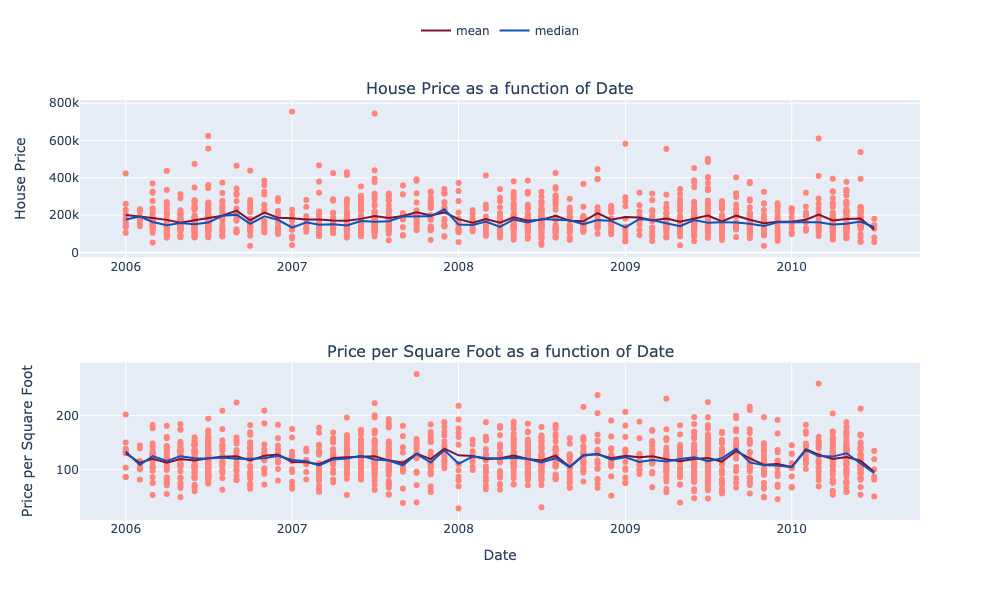

In [12]:
fig_eda_2 = make_subplots(rows=2, cols=1, 
                          subplot_titles=["House Price as a function of Date",
                                          "Price per Square Foot as a function of Date"])

fig_eda_2.add_trace( go.Scatter(x=price_temporal["date_sold"], y=price_temporal["sale_price"],
                          mode="markers", marker_color="#ff847c", showlegend=False),
                row=1, col=1)
fig_eda_2.add_trace( go.Scatter(x=price_temporal_ave["date_sold"], y=price_temporal_ave["sale_price"],
                          mode="lines", marker_color="#811331",
                          showlegend=True, legendgroup="mean", name="mean"),
                row=1, col=1)
fig_eda_2.add_trace( go.Scatter(x=price_temporal_med["date_sold"], y=price_temporal_med["sale_price"],
                          mode="lines", marker_color="#0F52BA",
                          showlegend=True, legendgroup="median", name="median"),
                row=1, col=1)


fig_eda_2.add_trace( go.Scatter(x=price_temporal["date_sold"], y=price_temporal["price_per_sf"],
                          mode="markers", marker_color="#ff847c", showlegend=False),
                row=2, col=1)
fig_eda_2.add_trace( go.Scatter(x=price_temporal_ave["date_sold"], y=price_temporal_ave["price_per_sf"],
                          mode="lines", marker_color="#811331",
                          showlegend=False, legendgroup="mean", name="mean"),
                row=2, col=1)
fig_eda_2.add_trace( go.Scatter(x=price_temporal_med["date_sold"], y=price_temporal_med["price_per_sf"],
                          mode="lines", marker_color="#0F52BA",
                          showlegend=False, legendgroup="median", name="median"),
                row=2, col=1)

fig_eda_2.update_xaxes(title_text="Date", row=2)

fig_eda_2.update_yaxes(title_text="House Price", row=1)
fig_eda_2.update_yaxes(title_text="Price per Square Foot", row=2)



fig_eda_2.update_layout(height=600, width=1000, legend=dict(yanchor="top", y=1.2, xanchor="left", x=0.4, orientation="h"))
fig_eda_2.show(renderer="png")


The price and price per square foot were relatively stable over time as shown in the plots above.

## House Characteristics

In [13]:
##### Building type
house_bldg_type = house_df[["sale_price", "neighborhood", "house_style", "bldg_type"]]

### group by building type only
house_bldg_type_1 =  house_bldg_type.groupby(["bldg_type"]).count().rename(columns={"sale_price":"count"}).reset_index()
house_bldg_type_1 = house_bldg_type_1[["bldg_type", "count"]]

### group by neighborhood and building type
house_bldg_type_2 = house_bldg_type.groupby(["neighborhood", "bldg_type"]).count()
house_bldg_type_2 = house_bldg_type_2["sale_price"].rename({"sale_price":"count"}).unstack().fillna(0)

house_bldg_type_3 = house_bldg_type_2.div(house_bldg_type_2.sum(axis=1), axis=0)

# house_bldg_type_4 = house_bldg_type.groupby(["neighborhood", "bldg_type"]).agg(["mean", "median"]).reset_index()


##### House style
house_style = house_df[["sale_price", "neighborhood", "house_style", "bldg_type"]]

house_style_1 = house_style.groupby(["house_style"]).count().rename(columns={"sale_price":"count"}).reset_index()
house_style_1 = house_style_1[["house_style", "count"]]

house_style_2 = house_style.groupby(["neighborhood", "house_style"]).count()
house_style_2 = house_style_2["sale_price"].rename({"sale_price":"count"}).unstack().fillna(0)

house_style_3 = house_style_2.div(house_style_2.sum(axis=1), axis=0)


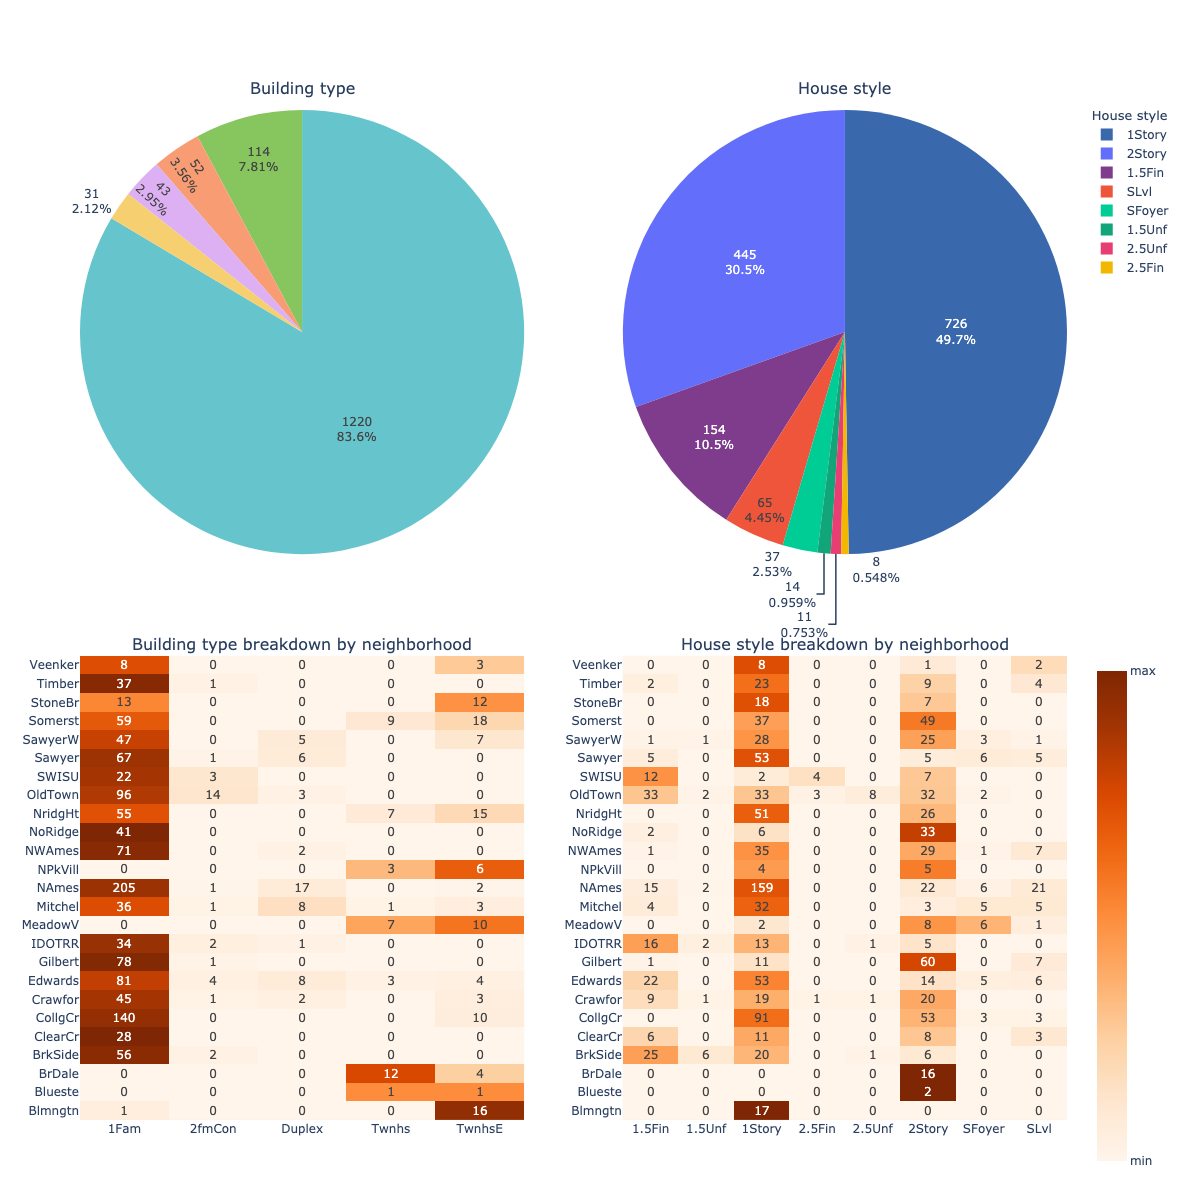

In [14]:
fig_eda_3 = make_subplots(rows=2, cols=2, vertical_spacing=0.09,
                    specs=[[{"type":"domain"}, {"type":"domain"}], [{"type":"xy"}, {"type":"xy"}]],
                    subplot_titles=["Building type", "House style", 
                                    "Building type breakdown by neighborhood", "House style breakdown by neighborhood"])

fig_eda_3.add_trace( go.Pie(values=house_bldg_type_1["count"], labels=house_bldg_type_1["bldg_type"],
                      textinfo="value+percent", 
                      marker=dict(colors=px.colors.qualitative.Pastel[0:len(house_bldg_type_1["bldg_type"])]),
                      legend="legend1", legendgroup="1", legendgrouptitle=dict(text="Building type")),
              row=1, col=1)

fig_eda_3.add_trace( go.Pie(values=house_style_1["count"], labels=house_style_1["house_style"], 
                      textinfo="value+percent",
                      marker=dict(colors=px.colors.qualitative.Bold[0:len(house_bldg_type_1["bldg_type"])]),
                      legend="legend2", legendgroup="2", legendgrouptitle=dict(text="House style")),
              row=1, col=2)

fig_eda_3.add_trace(go.Heatmap(x=house_bldg_type_3.columns, y=house_bldg_type_3.index, 
                         z=house_bldg_type_3, text=house_bldg_type_2, texttemplate="%{text:,.0f}",
                         colorscale="Oranges", 
                         colorbar=dict(tickvals=[0,1], ticktext=["min", "max"],
                                       len=0.5, y=0.2)
                         ),
            row=2, col=1)

fig_eda_3.add_trace(go.Heatmap(x=house_style_3.columns, y=house_style_3.index, 
                         z=house_style_3, text=house_style_2, texttemplate="%{text:,.0f}",
                         colorscale="Oranges",
                         colorbar=dict(tickvals=[0,1], ticktext=["min", "max"], len=0.5),
                         showscale=False
                         ),
            row=2, col=2)

fig_eda_3.update_layout(height=1200, width=1200, hovermode=False,
                  )
fig_eda_3.show(renderer="png")

----
# <center> Feature Selection </center>
----

Split data into categorical and numerical data type.

In [200]:
##### split numerical and categorical data
num_cleaned_house_df = cleaned_house_df.select_dtypes(include=np.number)
cat_cleaned_house_df = cleaned_house_df.select_dtypes(exclude=np.number)

num_cleaned_house_df.head(5)

ms_sub_class  lot_area  overall_qual  overall_cond  year_built  \
0            60      8450             7             5        2003   
1            20      9600             6             8        1976   
2            60     11250             7             5        2001   
3            70      9550             7             5        1915   
4            60     14260             8             5        2000   

   year_remod_add  mas_vnr_area  bsmt_fin_sf1  bsmt_fin_sf2  bsmt_unf_sf  ...  \
0            2003      196.0000           706             0          150  ...   
1            1976        0.0000           978             0          284  ...   
2            2002      162.0000           486             0          434  ...   
3            1970        0.0000           216             0          540  ...   
4            2000      350.0000           655             0          490  ...   

   open_porch_sf  enclosed_porch  3_ssn_porch  screen_porch  pool_area  \
0             61               0            0             0          0   
1              0               0            0             0          0   
2             42               0            0             0          0   
3             35             272            0             0          0   
4             84               0            0             0          0   

   misc_val  mo_sold  yr_sold  sale_price  age_sold  
0         0        2     2008      208500         5  
1         0        5     2007      181500        31  
2         0        9     2008      223500         7  
3         0        2     2006      140000        91  
4         0       12     2008      250000         8  

[5 rows x 37 columns]

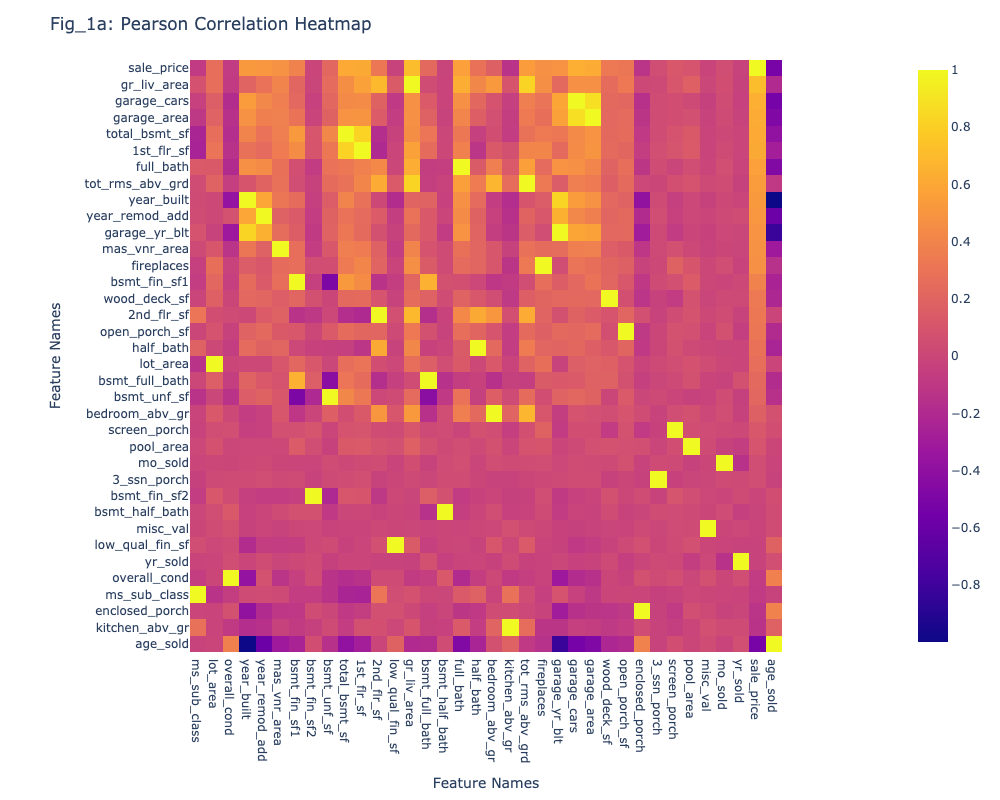

In [16]:
corr_matrix = num_cleaned_house_df.corr().sort_values("sale_price", ascending=False)
corr_matrix = corr_matrix.drop(columns=["overall_qual"]).drop(index=["overall_qual"])

fig_1a = px.imshow(corr_matrix)

fig_1a.update_xaxes(title_text="Feature Names")
fig_1a.update_yaxes(title_text="Feature Names")
fig_1a.update_layout(title_text="Fig_1a: Pearson Correlation Heatmap", height=800, width=1000)
fig_1a.show(renderer="png")

Fig_1a shows the heatmap of Pearson correlation matrix for features with numerical data type. The correlation compares two features at a time, and the correlation values can range from -1 to 1. When two features are negatively correlated, an increase in one feature decreases the other feature. On the other hand, when two features are positively correlated, an increase in one feature increases the other feature. A 0 correlation value means that the two features are not correlated, hence any increase or decrease in one feature does not affect the other feature.

The right most column of the heatmap shows how sale price is correlated to other feature. These values are extracted and plotted in Fig_1b.

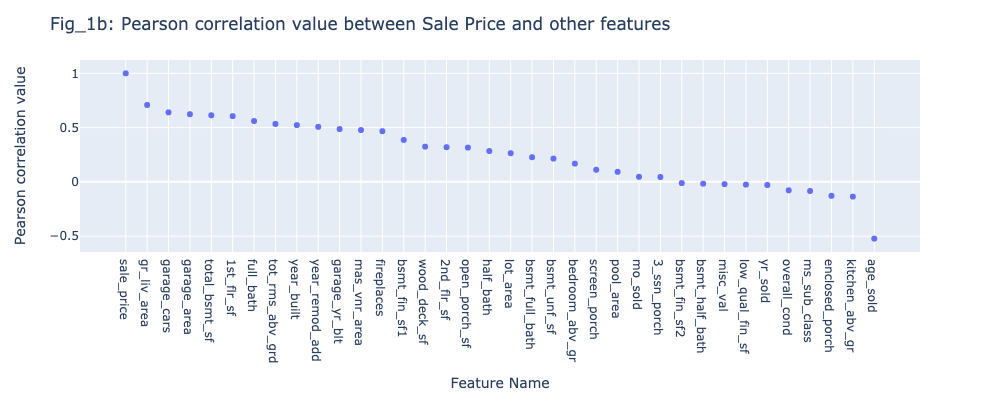

In [17]:
fig_1b = px.scatter(x=corr_matrix.index, y=corr_matrix["sale_price"])

fig_1b.update_xaxes(title_text="Feature Name")
fig_1b.update_yaxes(title_text="Pearson correlation value")
fig_1b.update_layout(title_text="Fig_1b: Pearson correlation value between Sale Price and other features", height=400, width=1000)
fig_1b.show(renderer="png")

Based on Fig_1b, some of the features that can be used to create a model are `gr_liv_area`, `garage_cars`, `garage_area`, `total_bsmt_sf`, and `1st_flr_sf`. The remainder features will not be included to avoid creating a complex model and potentially overfitting the model.

Additionally, `year_built`, `yr_sold`, `year_remod_add`, and `mo_sold` features were also included for feature engineering.



---
# <center> Model Development </center>
---

In [201]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

from scipy.stats import expon

In [236]:
# ##### For baseline 
# #####   * drop rows containing NaN
# #####   * use numerical data only
# num_X = num_cleaned_house_df.dropna()
# y = num_X["sale_price"]

# num_X = num_X.drop(columns=["sale_price"])

##### Actual model
num_cols = ["gr_liv_area", "garage_area", "total_bsmt_sf", "1st_flr_sf", "year_built", 
            "yr_sold", "year_remod_add", "mo_sold", "age_sold"]
cat_cols = ["neighborhood"]


##### For baseline -- drop rows containing NaN
num_X = num_cleaned_house_df.dropna()
# num_X = num_cleaned_house_df[num_cols]
cat_X = cleaned_house_df[cat_cols]

y = num_X["sale_price"]

num_X = num_X.drop(columns=["sale_price"])



#### Feature engineering
num_X["house_age"] = num_X["yr_sold"] - num_X["year_built"]
num_X.loc[num_X["house_age"]==0, "house_age"] = num_X.loc[num_X["house_age"]==0, "mo_sold"]/12
num_X.loc[num_X["age_sold"]==0, "age_sold"] = num_X.loc[num_X["age_sold"]==0, "mo_sold"]/12
num_X["scaled_remod"] = (num_X["year_remod_add"] - num_X["year_built"])/num_X["age_sold"]


##### Drop unnecessary columns
num_X = num_X.drop(columns=["year_built", "yr_sold", "mo_sold"])

X = num_X

##### Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=43)


##### create standard scaler
x_std_scaler = StandardScaler()
x_std_scaler.fit(X_train)

# y_scaler = PowerTransformer()
y_scaler = StandardScaler()
# y_scaler = RobustScaler()
y_scaler.fit(np.array(y_train).reshape(-1,1))

# ##### create one-hot encoder
# ohe_encoder = OneHotEncoder(sparse_output=False)
# ohe_encoder.fit(cat_X)


##### transform values using standard scaler
scaled_num_X_train = x_std_scaler.transform(X_train.select_dtypes(include=np.number))
scaled_num_X_test = x_std_scaler.transform(X_test.select_dtypes(include=np.number))

scaled_y_train = y_scaler.transform(np.array(y_train).reshape(-1,1)).reshape(1,-1)[0]
scaled_y_test = y_scaler.transform(np.array(y_test).reshape(-1,1)).reshape(1,-1)[0]

##### recreate dataframe after scaling and encoding
scaled_X_train_df = pd.DataFrame(data=scaled_num_X_train, columns=x_std_scaler.feature_names_in_)
scaled_X_test_df = pd.DataFrame(data=scaled_num_X_test, columns=x_std_scaler.feature_names_in_)

X_train = scaled_X_train_df
X_test = scaled_X_test_df




In [237]:
X_train.columns

Index(['ms_sub_class', 'lot_area', 'overall_qual', 'overall_cond',
       'year_remod_add', 'mas_vnr_area', 'bsmt_fin_sf1', 'bsmt_fin_sf2',
       'bsmt_unf_sf', 'total_bsmt_sf', '1st_flr_sf', '2nd_flr_sf',
       'low_qual_fin_sf', 'gr_liv_area', 'bsmt_full_bath', 'bsmt_half_bath',
       'full_bath', 'half_bath', 'bedroom_abv_gr', 'kitchen_abv_gr',
       'tot_rms_abv_grd', 'fireplaces', 'garage_yr_blt', 'garage_cars',
       'garage_area', 'wood_deck_sf', 'open_porch_sf', 'enclosed_porch',
       '3_ssn_porch', 'screen_porch', 'pool_area', 'misc_val', 'age_sold',
       'house_age', 'scaled_remod'],
      dtype='object')

New features were generated using feature engineering. The new features include `age_sold` and `scaled_remod`. `age_sold` is the age of the house in years since it was built. This value was computed as `yr_sold` - `year_built`. If the house was sold in the same year it was built, then the month the house was sold will be divided by 12 to convert the house age to year. `scaled_remod` is the time when the house was remodeled scaled to its age. This value was computed as (`year_remod_add` - `year_built`)/`age_sold`.

After some experimentation, `garage_cars` feature were dropped since it did not improve the model accuracy. The categorical data were also found to not significantly improve the model accuracy.

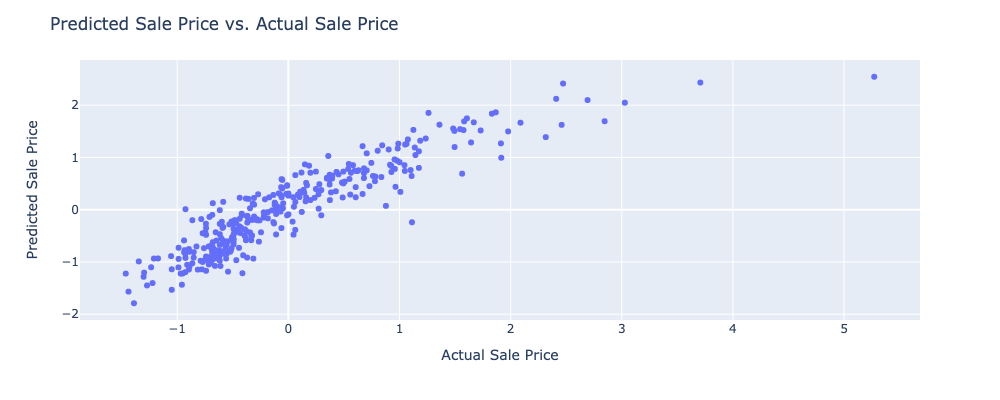

Train set score: 0.8006576962452295
Test set score: 0.8303332449472689


In [217]:
##### Linear Regression model -- Based line

lr_mod = LinearRegression()

lr_mod.fit(X_train, scaled_y_train)

fig_2a = px.scatter(x=scaled_y_test.reshape(1,-1)[0], y=lr_mod.predict(X_test).reshape(1,-1)[0])

fig_2a.update_xaxes(title_text="Actual Sale Price")
fig_2a.update_yaxes(title_text="Predicted Sale Price")
fig_2a.update_layout(title_text="Predicted Sale Price vs. Actual Sale Price",  height=400, width=1000)
fig_2a.show(renderer="png")

print(f"Train set score: {lr_mod.score(X_train, scaled_y_train)}")
print(f"Test set score: {lr_mod.score(X_test, scaled_y_test)}")


In [238]:
##### Random forest regressor
rfr_mdl = RandomForestRegressor(min_samples_split=0.2, 
                                max_samples=0.75,
                                n_estimators=200,
                                ccp_alpha=10)

rfr_dist = dict(min_samples_split = uniform().rvs(size=1000),
                max_samples = uniform().rvs(size=1000),
                n_estimators = randint(high=1500, low=50).rvs(size=300),
                # ccp_alpha = randint(high=100, low=1).rvs(size=1000)/10000
                ccp_alpha = expon.rvs(loc=0, scale=0.001, size=1000)
                )

rscv_rfr = RandomizedSearchCV(rfr_mdl, rfr_dist, random_state=43, n_iter=30, verbose=3, cv=10)
search_rfr = rscv_rfr.fit(scaled_X_train_df, scaled_y_train)

clear_output()

best_params_rfr = search_rfr.best_params_
search_rfr.best_score_

0.8185465425499364

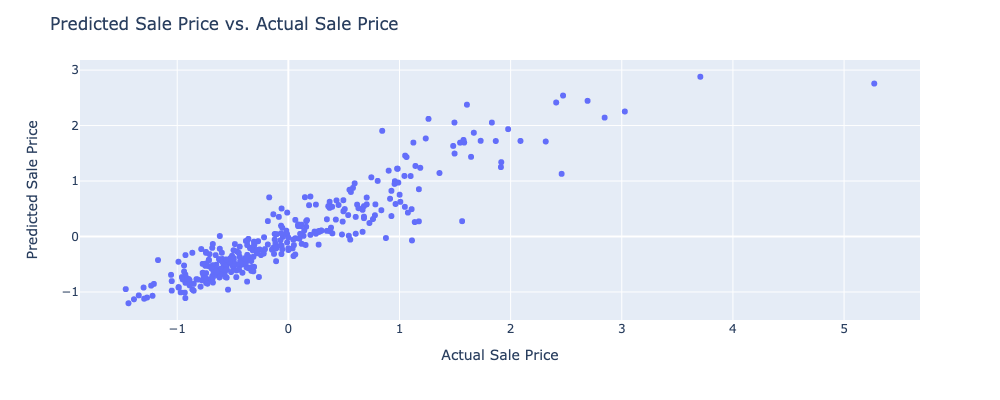

Test set score: 0.8545020516256795


In [239]:

final_rfr_mdl = RandomForestRegressor(min_samples_split=best_params_rfr["min_samples_split"], 
                                      max_samples=best_params_rfr["max_samples"],
                                      n_estimators=best_params_rfr["n_estimators"],
                                      ccp_alpha=best_params_rfr["ccp_alpha"])
final_rfr_mdl.fit(X_train, scaled_y_train)

fig_5a = px.scatter(x=scaled_y_test, y=final_rfr_mdl.predict(X_test))

fig_5a.update_xaxes(title_text="Actual Sale Price")
fig_5a.update_yaxes(title_text="Predicted Sale Price")
fig_5a.update_layout(title_text="Predicted Sale Price vs. Actual Sale Price", height=400, width=1000)
fig_5a.show(renderer="png")

print(f"Test set score: {final_rfr_mdl.score(X_test, scaled_y_test)}")

In [222]:
##### Gradient Boosting Regressor
gbr_mdl = GradientBoostingRegressor(n_estimators= 500,
                                    max_depth= 10,
                                    min_samples_split= 10,
                                    learning_rate = 0.2,
                                    loss = "squared_error",
                                    ccp_alpha = 100)


gbr_dist = dict(n_estimators = randint(high=1500, low=50).rvs(size=300),
                max_depth = randint(high=1500, low=3).rvs(size=300),
                min_samples_split = uniform().rvs(size=1000),
                learning_rate = uniform().rvs(size=1000),
                # ccp_alpha = randint(high=10, low=1).rvs(size=1000)/1000
                ccp_alpha = uniform().rvs(size=1000)/1000
                )

rscv_gbr = RandomizedSearchCV(gbr_mdl, gbr_dist, random_state=43, n_iter=30, verbose=3, cv=10)
search_gbr = rscv_gbr.fit(scaled_X_train_df, scaled_y_train)
clear_output()

best_params_gbr = search_gbr.best_params_
search_gbr.best_score_


0.9976643728581414

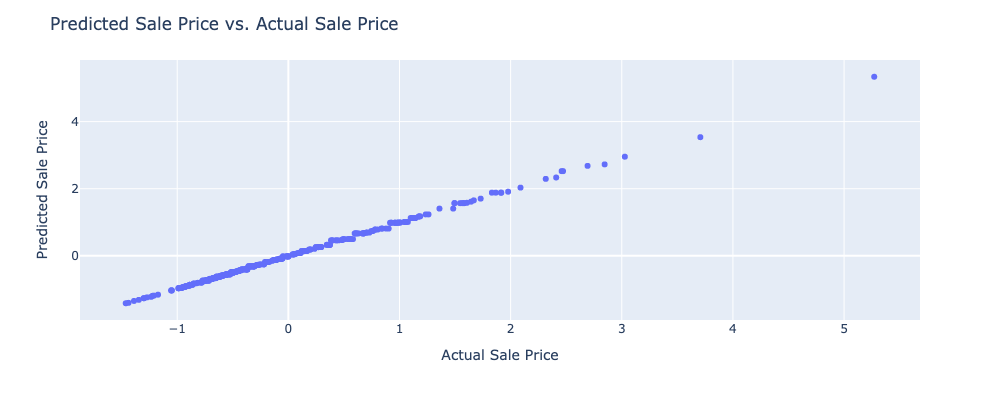

Testing score: 0.9989756586734952


In [223]:
final_gbr_mdl = GradientBoostingRegressor(n_estimators= best_params_gbr["n_estimators"],
                                          max_depth= best_params_gbr["max_depth"],
                                          min_samples_split= best_params_gbr["min_samples_split"],
                                          learning_rate = best_params_gbr["learning_rate"], 
                                          loss = "squared_error",
                                          ccp_alpha = best_params_gbr["ccp_alpha"])
final_gbr_mdl.fit(scaled_X_train_df, scaled_y_train)

fig_6a = px.scatter(x=scaled_y_test, y=final_gbr_mdl.predict(X_test))

fig_6a.update_xaxes(title_text="Actual Sale Price")
fig_6a.update_yaxes(title_text="Predicted Sale Price")
fig_6a.update_layout(title_text="Predicted Sale Price vs. Actual Sale Price",  height=400, width=1000)
fig_6a.show(renderer="png")


print(f"Testing score: {final_gbr_mdl.score(scaled_X_test_df, scaled_y_test)}")

3 models were used for prediction: linear regression, random forest regression, and gradient boosting regression. The score for each model is 0.7276, 0.7967, and 0.6868, respectively. Based on this, random forest regression perform the best among the 3 models. Thus, random forest model was used to make prediction for the testing set.

----
# <center>Testing Set </center>
----

The following testing set was obtained as part of the House Prices -- Advance Regression Techniques competition on Kaggle. Random Forest Regression was selected to be used to predict the house prices based on the selected features. The predicted house price was then submitted to Kaggle for evaluation.

In [241]:
house_testing_set = pd.read_csv("house_price_test.csv")
house_testing_set.columns = [infl.underscore(val) for val in house_testing_set.columns]
id_col = house_testing_set["id"]


house_testing_set = house_testing_set.select_dtypes(include=np.number)
house_testing_set = house_testing_set.drop(columns=["id", "lot_frontage"])
house_testing_set["age_sold"] = house_testing_set["yr_sold"] - house_testing_set["year_built"]


# id_col = house_testing_set["id"]

# coi_testing = ["gr_liv_area", "garage_area", "total_bsmt_sf", "1st_flr_sf", "year_built", 
#                 "yr_sold", "year_remod_add", "mo_sold", "age_sold"]

# house_testing_set = house_testing_set[coi_testing]

# #### Feature engineering
# num_X["house_age"] = num_X["yr_sold"] - num_X["year_built"]
# num_X.loc[num_X["house_age"]==0, "house_age"] = num_X.loc[num_X["house_age"]==0, "mo_sold"]/12
# num_X.loc[num_X["age_sold"]==0, "age_sold"] = num_X.loc[num_X["age_sold"]==0, "mo_sold"]/12
# num_X["scaled_remod"] = (num_X["year_remod_add"] - num_X["year_built"])/num_X["age_sold"]

##### Feature engineering
house_testing_set["house_age"] = house_testing_set["yr_sold"] - house_testing_set["year_built"]
house_testing_set.loc[house_testing_set["house_age"]==0, "house_age"] = house_testing_set.loc[house_testing_set["house_age"]==0, "mo_sold"]/12
house_testing_set.loc[house_testing_set["age_sold"]==0, "age_sold"] = house_testing_set.loc[house_testing_set["age_sold"]==0, "mo_sold"]/12
house_testing_set["scaled_remod"] = (house_testing_set["year_remod_add"] - house_testing_set["year_built"])/house_testing_set["age_sold"]

##### Drop unnecessary columns
house_testing_set = house_testing_set.drop(columns=["year_built", "yr_sold", "mo_sold"])

##### fillna
house_testing_set = house_testing_set.fillna(0)

##### transform values
scaled_testing_set = x_std_scaler.transform(house_testing_set)

##### recreate dataframe after scaling and encoding
house_testing_set = pd.DataFrame(data=scaled_testing_set, columns=x_std_scaler.feature_names_in_)

house_testing_set

ms_sub_class  lot_area  overall_qual  overall_cond  year_remod_add  \
0          -0.8863    0.1294       -0.8660        0.4098         -1.1975   
1          -0.8863    0.4219       -0.1333        0.4098         -1.3454   
2           0.0799    0.3736       -0.8660       -0.5120          0.6275   
3           0.0799   -0.0523       -0.1333        0.4098          0.6275   
4           1.5292   -0.6022        1.3321       -0.5120          0.3316   
...            ...       ...           ...           ...             ...   
1454        2.4954   -0.9416       -1.5986        1.3316         -0.7535   
1455        2.4954   -0.9462       -1.5986       -0.5120         -0.7535   
1456       -0.8863    1.0559       -0.8660        1.3316          0.5289   
1457        0.6838   -0.0011       -0.8660       -0.5120          0.3316   
1458        0.0799   -0.0912        0.5994       -0.5120          0.4302   

      mas_vnr_area  bsmt_fin_sf1  bsmt_fin_sf2  bsmt_unf_sf  total_bsmt_sf  \
0          -0.6129        0.0391        0.5233      -0.6715        -0.4191   
1          -0.0093        1.0190       -0.3050      -0.3621         0.5879   
2          -0.6129        0.7347       -0.3050      -0.9740        -0.3155   
3          -0.5011        0.3276       -0.3050      -0.5486        -0.3200   
4          -0.6129       -0.4024       -0.3050       1.0279         0.4775   
...            ...           ...           ...          ...            ...   
1454       -0.6129       -0.9688       -0.3050      -0.0436        -1.1761   
1455       -0.6129       -0.4261       -0.3050      -0.6169        -1.1761   
1456       -0.6129        1.6672       -0.3050      -1.2857         0.3514   
1457       -0.6129       -0.2431       -0.3050       0.0224        -0.3515   
1458       -0.0875        0.6636       -0.3050      -0.7443        -0.1623   

      ...  wood_deck_sf  open_porch_sf  enclosed_porch  3_ssn_porch  \
0     ...        0.3481        -0.7146         -0.3426      -0.1081   
1     ...        2.3620        -0.1679         -0.3426      -0.1081   
2     ...        0.9212        -0.1983         -0.3426      -0.1081   
3     ...        2.0993        -0.1679         -0.3426      -0.1081   
4     ...       -0.7663         0.5308         -0.3426      -0.1081   
...   ...           ...            ...             ...          ...   
1454  ...       -0.7663        -0.7146         -0.3426      -0.1081   
1455  ...       -0.7663        -0.3501         -0.3426      -0.1081   
1456  ...        3.0067        -0.7146         -0.3426      -0.1081   
1457  ...       -0.1295        -0.2286         -0.3426      -0.1081   
1458  ...        0.7461         0.0144         -0.3426      -0.1081   

      screen_porch  pool_area  misc_val  age_sold  house_age  scaled_remod  
0           1.7255    -0.0762   -0.1155    0.4777     0.4777       -0.6916  
1          -0.2878    -0.0762   40.3319    0.5798     0.5798       -0.6916  
2          -0.2878    -0.0762   -0.1155   -0.7472    -0.7472       -0.4744  
3          -0.2878    -0.0762   -0.1155   -0.7813    -0.7813       -0.6916  
4           2.1282    -0.0762   -0.1155   -0.5771    -0.5771       -0.6916  
...            ...        ...       ...       ...        ...           ...  
1454       -0.2878    -0.0762   -0.1155    0.0354     0.0354       -0.6916  
1455       -0.2878    -0.0762   -0.1155    0.0354     0.0354       -0.6916  
1456       -0.2878    -0.0762   -0.1155    0.3757     0.3757        1.5175  
1457       -0.2878    -0.0762    2.1496   -0.7132    -0.7132       -0.6916  
1458       -0.2878    -0.0762   -0.1155   -0.7472    -0.7472       -0.4744  

[1459 rows x 35 columns]

In [251]:
prediction = final_rfr_mdl.predict(house_testing_set)

submission = pd.DataFrame(list(zip(id_col, prediction)), columns=["Id", "SalePrice"])
submission["SalePrice"] = y_scaler.inverse_transform(submission["SalePrice"].to_numpy().reshape(-1,1))
submission

submission.to_csv("submission_house.csv", index=False)

The submission_house.csv was submitted to the page on Kaggle to receive the final score.

----
# <center>Regression Analysis </center>
----

This part is used to investigate the performance of the model built above.

In [37]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score as r2


In [206]:
y_linreg_train = lr_mod.predict(X_train)
y_rfr_train = final_rfr_mdl.predict(X_train)
y_gbr_train = final_gbr_mdl.predict(X_train)

reg_analysis_train = pd.DataFrame(list(zip(scaled_y_train, y_linreg_train, y_rfr_train, y_gbr_train)),
                            columns=["actual_price", "linear_regression", "random_forest", "gradient_boost"])

r2_score_train = []
mae_score_train = []
mape_score_train = []

for val in reg_analysis_train.columns:

    if val!="actual_price":
        r2_score_train.append(r2(reg_analysis_train["actual_price"], reg_analysis_train[val]))
        mae_score_train.append(mae(reg_analysis_train["actual_price"], reg_analysis_train[val]))
        mape_score_train.append(mape(reg_analysis_train["actual_price"], reg_analysis_train[val]))


y_linreg_test = lr_mod.predict(X_test)
y_rfr_test = final_rfr_mdl.predict(X_test)
y_gbr_test = final_gbr_mdl.predict(X_test)

reg_analysis_test = pd.DataFrame(list(zip(scaled_y_test, y_linreg_test, y_rfr_test, y_gbr_test)),
                            columns=["actual_price", "linear_regression", "random_forest", "gradient_boost"])

r2_score_test = []
mae_score_test = []
mape_score_test = []

for val in reg_analysis_test.columns:

    if val!="actual_price":
        r2_score_test.append(r2(reg_analysis_test["actual_price"], reg_analysis_test[val]))
        mae_score_test.append(mae(reg_analysis_test["actual_price"], reg_analysis_test[val]))
        mape_score_test.append(mape(reg_analysis_test["actual_price"], reg_analysis_test[val]))



reg_models = ["linear", "random_forest", "gradient_boost"]
train_scores = pd.DataFrame(list(zip(reg_models, r2_score_train, mae_score_train, mape_score_train,
                                      r2_score_test, mae_score_test, mape_score_test)), 
                            columns=["model", "r2_train", "mae_train", "mape_train", "r2_test", "mae_test", "mape_test"])

train_scores



model  r2_train  mae_train           mape_train  r2_test  \
0          linear    0.7259     0.3071 958,332,768,696.7474   0.7277   
1   random_forest    0.8198     0.2453  52,707,950,671.7388   0.7869   
2  gradient_boost    0.9079     0.2126 644,292,035,266.7946   0.6584   

   mae_test  mape_test  
0    0.3236     2.3352  
1    0.2868     2.1703  
2    0.3207     2.3210

In [207]:
##### Calculate residuals for train and test sets
linreg_train_residual = scaled_y_train - y_linreg_train
rfr_train_residual = scaled_y_train - y_rfr_train
gbr_train_residual = scaled_y_train - y_gbr_train

linreg_test_residual = scaled_y_test - y_linreg_test
rfr_test_residual = scaled_y_test - y_rfr_test
gbr_test_residual = scaled_y_test - y_gbr_test

##### Calculate z-scores for residual qq-plot
sorted_linreg_train_residual = sorted(linreg_train_residual)
sorted_rfr_train_residual = sorted(rfr_train_residual)
sorted_gbr_train_residual = sorted(gbr_train_residual)

sorted_linreg_test_residual = sorted(linreg_test_residual)
sorted_rfr_test_residual = sorted(rfr_test_residual)
sorted_gbr_test_residual = sorted(gbr_test_residual)

linreg_train_residual_zscore = (sorted_linreg_train_residual - np.mean(sorted_linreg_train_residual))/np.std(sorted_linreg_train_residual)
rfr_train_residual_zscore = (sorted_rfr_train_residual - np.mean(sorted_rfr_train_residual))/np.std(sorted_rfr_train_residual)
gbr_train_residual_zscore = (sorted_gbr_train_residual - np.mean(sorted_gbr_train_residual))/np.std(sorted_gbr_train_residual)

linreg_test_residual_zscore = (sorted_linreg_test_residual - np.mean(sorted_linreg_test_residual))/np.std(sorted_linreg_test_residual)
rfr_test_residual_zscore = y_test - y_rfr_test
gbr_test_residual_zscore = y_test - y_gbr_test



# rfr_residual = y_test - rfr_predicted_y
# rfr_z_score = (rfr_residual - np.mean(rfr_residual))/np.std(rfr_residual)
# rfr_z_score = (rfr_residual - np.mean(rfr_residual))/np.std(rfr_residual)
# 

In [208]:
fig = make_subplots(rows=2, cols=3)

training_result = [go.Scatter(x=scaled_y_train, y=y_linreg_train, mode="markers"
                              , marker=dict(color="#0096FF", size=3, opacity=0.8)
                              , showlegend=True, legendgroup="train", name="train"),
                   go.Scatter(x=scaled_y_train, y=y_rfr_train, mode="markers"
                              , marker=dict(color="#0096FF", size=3, opacity=0.8)
                              , showlegend=False, legendgroup="train", name="train"),
                   go.Scatter(x=scaled_y_train, y=y_gbr_train, mode="markers"
                              , marker=dict(color="#0096FF", size=3, opacity=0.8)
                              , showlegend=False, legendgroup="train", name="train")]

testing_result = [go.Scatter(x=scaled_y_test, y=y_linreg_test, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=True, legendgroup="test", name="test"),
                   go.Scatter(x=scaled_y_test, y=y_rfr_test, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=False, legendgroup="test", name="test"),
                   go.Scatter(x=scaled_y_test, y=y_gbr_test, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=False, legendgroup="test", name="test")]

training_residuals = [go.Scatter(x=scaled_y_train, y=linreg_train_residual, mode="markers"
                              , marker=dict(color="#0096FF", size=3, opacity=0.8)
                              , showlegend=True, legendgroup="train", name="train"),
                        go.Scatter(x=scaled_y_train, y=rfr_train_residual, mode="markers"
                                    , marker=dict(color="#0096FF", size=3, opacity=0.8)
                                    , showlegend=False, legendgroup="train", name="train"),
                        go.Scatter(x=scaled_y_train, y=gbr_train_residual, mode="markers"
                                    , marker=dict(color="#0096FF", size=3, opacity=0.8)
                                    , showlegend=False, legendgroup="train", name="train")]

testing_residuals = [go.Scatter(x=scaled_y_test, y=linreg_test_residual, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=True, legendgroup="test", name="test"),
                   go.Scatter(x=scaled_y_test, y=rfr_test_residual, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=False, legendgroup="test", name="test"),
                   go.Scatter(x=scaled_y_test, y=gbr_test_residual, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=False, legendgroup="test", name="test")]

training_residuals_qqplot = [go.Scatter(x=linreg_train_residual_zscore, y=sorted_linreg_train_residual, mode="markers"
                              , marker=dict(color="#0096FF", size=3, opacity=0.8)
                              , showlegend=True, legendgroup="train", name="train"),
                                go.Scatter(x=rfr_train_residual_zscore, y=sorted_rfr_train_residual, mode="markers"
                                            , marker=dict(color="#0096FF", size=3, opacity=0.8)
                                            , showlegend=False, legendgroup="train", name="train"),
                                go.Scatter(x=gbr_train_residual_zscore, y=sorted_gbr_train_residual, mode="markers"
                                            , marker=dict(color="#0096FF", size=3, opacity=0.8)
                                            , showlegend=False, legendgroup="train", name="train")]

testing_residuals_qqplot = [go.Scatter(x=linreg_test_residual_zscore, y=sorted_linreg_test_residual, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=True, legendgroup="test", name="test"),
                            go.Scatter(x=rfr_test_residual_zscore, y=sorted_rfr_test_residual, mode="markers"
                                        , marker=dict(color="#DC143C", size=3, opacity=0.7)
                                        , showlegend=False, legendgroup="test", name="test"),
                            go.Scatter(x=gbr_test_residual_zscore, y=sorted_gbr_train_residual, mode="markers"
                                        , marker=dict(color="#DC143C", size=3, opacity=0.7)
                                        , showlegend=False, legendgroup="test", name="test")]


for index, trace in enumerate(training_result):
    fig.add_trace(trace, row=1, col=index+1)

for index, trace in enumerate(testing_result):
    fig.add_trace(trace, row=1, col=index+1)

for index, trace in enumerate(training_residuals):
    fig.add_trace(trace, row=2, col=index+1)

for index, trace in enumerate(testing_residuals):
    fig.add_trace(trace, row=2, col=index+1)

# for index, trace in enumerate(training_residuals_qqplot):
#     fig.add_trace(trace, row=3, col=index+1)

# for index, trace in enumerate(testing_residuals_qqplot):
#     fig.add_trace(trace, row=3, col=index+1)


fig.update_layout( height=600)

fig.show()

In [62]:
fig = make_subplots(rows=2, cols=3)

training_result = [go.Scatter(x=y_train, y=y_linreg_train, mode="markers"
                              , marker=dict(color="#0096FF", size=3, opacity=0.8)
                              , showlegend=True, legendgroup="train", name="train"),
                   go.Scatter(x=y_train, y=y_rfr_train, mode="markers"
                              , marker=dict(color="#0096FF", size=3, opacity=0.8)
                              , showlegend=False, legendgroup="train", name="train"),
                   go.Scatter(x=y_train, y=y_gbr_train, mode="markers"
                              , marker=dict(color="#0096FF", size=3, opacity=0.8)
                              , showlegend=False, legendgroup="train", name="train")]

testing_result = [go.Scatter(x=y_test, y=y_linreg_test, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=True, legendgroup="test", name="test"),
                   go.Scatter(x=y_test, y=y_rfr_test, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=False, legendgroup="test", name="test"),
                   go.Scatter(x=y_test, y=y_gbr_test, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=False, legendgroup="test", name="test")]

training_residuals = [go.Scatter(x=y_train, y=linreg_train_residual, mode="markers"
                              , marker=dict(color="#0096FF", size=3, opacity=0.8)
                              , showlegend=True, legendgroup="train", name="train"),
                        go.Scatter(x=y_train, y=rfr_train_residual, mode="markers"
                                    , marker=dict(color="#0096FF", size=3, opacity=0.8)
                                    , showlegend=False, legendgroup="train", name="train"),
                        go.Scatter(x=y_train, y=gbr_train_residual, mode="markers"
                                    , marker=dict(color="#0096FF", size=3, opacity=0.8)
                                    , showlegend=False, legendgroup="train", name="train")]

testing_residuals = [go.Scatter(x=y_test, y=linreg_test_residual, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=True, legendgroup="test", name="test"),
                   go.Scatter(x=y_test, y=rfr_test_residual, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=False, legendgroup="test", name="test"),
                   go.Scatter(x=y_test, y=gbr_test_residual, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=False, legendgroup="test", name="test")]

training_residuals_qqplot = [go.Scatter(x=linreg_train_residual_zscore, y=sorted_linreg_train_residual, mode="markers"
                              , marker=dict(color="#0096FF", size=3, opacity=0.8)
                              , showlegend=True, legendgroup="train", name="train"),
                                go.Scatter(x=rfr_train_residual_zscore, y=sorted_rfr_train_residual, mode="markers"
                                            , marker=dict(color="#0096FF", size=3, opacity=0.8)
                                            , showlegend=False, legendgroup="train", name="train"),
                                go.Scatter(x=gbr_train_residual_zscore, y=sorted_gbr_train_residual, mode="markers"
                                            , marker=dict(color="#0096FF", size=3, opacity=0.8)
                                            , showlegend=False, legendgroup="train", name="train")]

testing_residuals_qqplot = [go.Scatter(x=linreg_test_residual_zscore, y=sorted_linreg_test_residual, mode="markers"
                              , marker=dict(color="#DC143C", size=3, opacity=0.7)
                              , showlegend=True, legendgroup="test", name="test"),
                            go.Scatter(x=rfr_test_residual_zscore, y=sorted_rfr_test_residual, mode="markers"
                                        , marker=dict(color="#DC143C", size=3, opacity=0.7)
                                        , showlegend=False, legendgroup="test", name="test"),
                            go.Scatter(x=gbr_test_residual_zscore, y=sorted_gbr_train_residual, mode="markers"
                                        , marker=dict(color="#DC143C", size=3, opacity=0.7)
                                        , showlegend=False, legendgroup="test", name="test")]


for index, trace in enumerate(training_result):
    fig.add_trace(trace, row=1, col=index+1)

for index, trace in enumerate(testing_result):
    fig.add_trace(trace, row=1, col=index+1)

for index, trace in enumerate(training_residuals):
    fig.add_trace(trace, row=2, col=index+1)

for index, trace in enumerate(testing_residuals):
    fig.add_trace(trace, row=2, col=index+1)

# for index, trace in enumerate(training_residuals_qqplot):
#     fig.add_trace(trace, row=3, col=index+1)

# for index, trace in enumerate(testing_residuals_qqplot):
#     fig.add_trace(trace, row=3, col=index+1)


fig.update_layout( height=600)

fig.show()



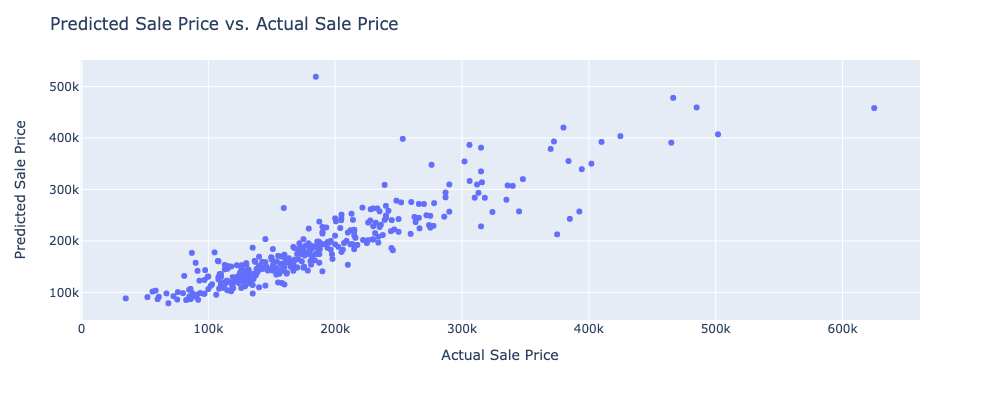

Test set score: 0.7981282544217142


In [26]:
fig_2a = px.scatter(x=y_test, y=final_rfr_mdl.predict(scaled_X_test_df))

fig_2a.update_xaxes(title_text="Actual Sale Price")
fig_2a.update_yaxes(title_text="Predicted Sale Price")
fig_2a.update_layout(title_text="Predicted Sale Price vs. Actual Sale Price",  height=400, width=1000)
fig_2a.show(renderer="png")


print(f"Test set score: {final_rfr_mdl.score(scaled_X_test_df, y_test)}")

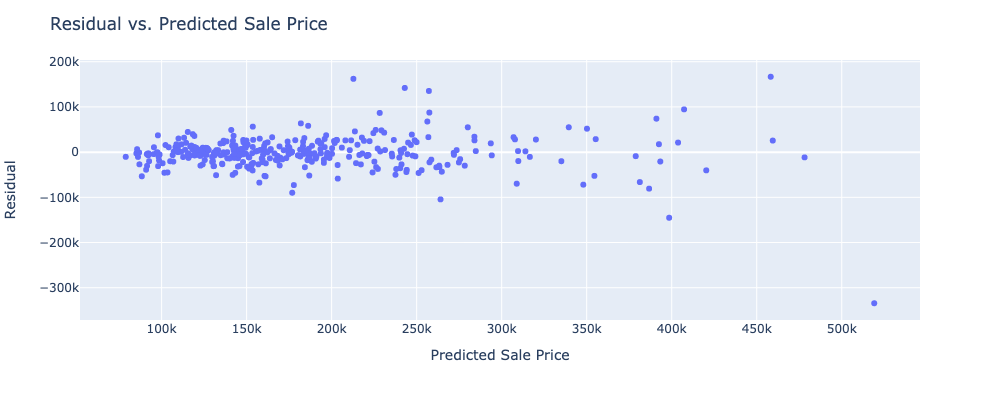

In [28]:
rfr_predicted_y = final_rfr_mdl.predict(scaled_X_test_df)
rfr_residual = y_test - rfr_predicted_y
rfr_z_score = (rfr_residual - np.mean(rfr_residual))/np.std(rfr_residual)

fig_2b = px.scatter(x=rfr_predicted_y, y=rfr_residual)

fig_2b.update_xaxes(title_text="Predicted Sale Price")
fig_2b.update_yaxes(title_text="Residual")
fig_2b.update_layout(title_text="Residual vs. Predicted Sale Price",  height=400, width=1000)
fig_2b.show(renderer="png")

Based on residual vs. predicted sale price, it can be seen that the random forest model performed relatively good at the lower end of the house price. As the house price increases, the model performance deteriorate. In order to enhance the model ability to make better prediction, something has to be done for house with higher price.

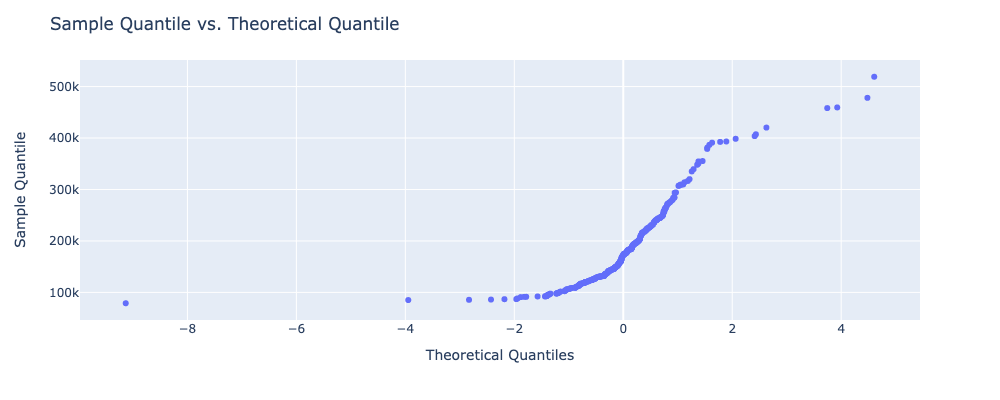

In [29]:
fig_2c = px.scatter(x=sorted(rfr_z_score), y=sorted(rfr_predicted_y))

fig_2c.update_xaxes(title_text="Theoretical Quantiles")
fig_2c.update_yaxes(title_text="Sample Quantile")
fig_2c.update_layout(title_text="Sample Quantile vs. Theoretical Quantile",  height=400, width=1000)
fig_2c.show(renderer="png")